# Fully Convolutional Networks for Semantic Segmentation

Let's start by importing the modules we'll need.

In [1]:
import os, sys, tarfile
from time import time

import mxnet as mx
from mxnet import autograd, gluon, image, init, nd
from mxnet.gluon import nn

import matplotlib.pyplot as plt
import numpy as np

/home/ubuntu/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Download and extract PASCAL VOC dataset.

In [2]:
data_root = './data'
voc_root = data_root + '/VOCdevkit/VOC2012'
url = ('http://host.robots.ox.ac.uk/pascal/VOC/voc2012'
       '/VOCtrainval_11-May-2012.tar')
sha1 = '4e443f8a2eca6b1dac8a6c57641b67dd40621a49'

fname = gluon.utils.download(url, data_root, sha1_hash=sha1)

if not os.path.isfile(voc_root+'/ImageSets/Segmentation/train.txt'):
    with tarfile.open(fname, 'r') as f:
        f.extractall(data_root)

### Explore the dataset.

How many training images are there?

```
VOCdevkit/VOC2012/ImageSets/Segmentation$ wc -l train.txt
1464 train.txt
```

How many validation images are there?

```
VOCdevkit/VOC2012/ImageSets/Segmentation$ wc -l val.txt
1449 val.txt
```

What is inside these text files?

```
VOCdevkit/VOC2012/ImageSets/Segmentation$ head -n5 train.txt
2007_000032
2007_000039
2007_000063
2007_000068
2007_000121
```

Where is the image?

```
VOCdevkit/VOC2012$ ls JPEGImages/2007_000032*
JPEGImages/2007_000032.jpg
```

Where is the label?

```
VOCdevkit/VOC2012$ ls SegmentationClass/2007_000032*
SegmentationClass/2007_000032.png
```

How do the images and labels look like? Let's write a couple of helpers to find out.

`read_dataset` is a helper to read all images and labels from the segmentation dataset into memory. It reads the images and label using `mxnet.image.imread` and stores into Python lists.

In [3]:
def read_dataset(root=voc_root, train=True):
    """Read image and label from segmentation training set"""
    txt_fname = root + '/ImageSets/Segmentation/' + (
        'train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    n = len(images)
    data, label = [None] * n, [None] * n
    for i, fname in enumerate(images):
        data[i] = image.imread('%s/JPEGImages/%s.jpg' % (
            root, fname))
        label[i] = image.imread('%s/SegmentationClass/%s.png' % (
            root, fname))
    return data, label

`show_images` is a helper to display images in rows and colums in notebook.

In [4]:
def show_images(imgs, nrows, ncols, figsize=None):
    """plot a list of images"""
    if not figsize:
        figsize = (ncols, nrows)
    _, figs = plt.subplots(nrows, ncols, figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            figs[i][j].imshow(imgs[i*ncols+j].asnumpy())
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False)
    plt.show()

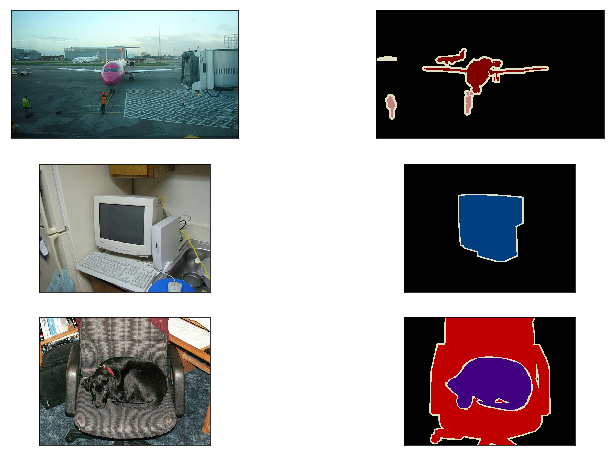

In [5]:
# Read images and labels
train_images, train_labels = read_dataset()

# Load three image/label pair into a list ...
imgs = []
for i in range(3):
    imgs += [train_images[i], train_labels[i]]
    
# ... and display the image/label pairs.
show_images(imgs, nrows=3, ncols=2, figsize=(12,8))

In [6]:
# Display the shape of images and labels
[im.shape for im in imgs]

[(281, 500, 3),
 (281, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3),
 (375, 500, 3)]

Notice that the images are of different sizes. To fit multiple images into a batch, we need images of same size. 

If we resize the images, we need to resize the labels too. It is hard to figure out which pixel belongs to which class after resizing the label.

So, instead of resizing, we will just randomly cut a fixed-size area and cut the label image at the same position.

In [7]:
def rand_crop(data, label, height, width):
    data, rect = image.random_crop(data, (width, height))
    label = image.fixed_crop(label, *rect)
    return data, label

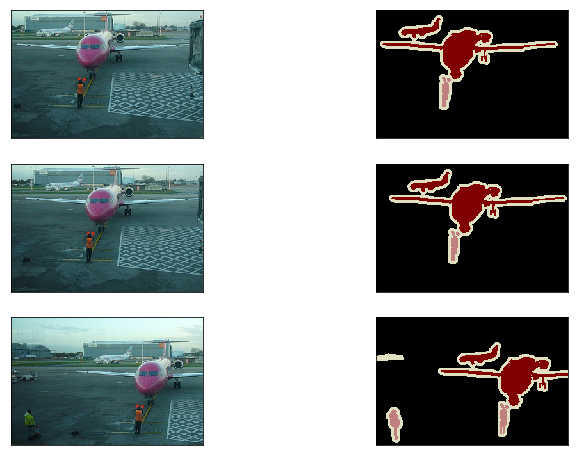

In [8]:
# Let's test rand_crop
imgs = []
for _ in range(3):
    imgs += rand_crop(train_images[0], train_labels[0],
                      200, 300)

show_images(imgs, nrows=3, ncols=2, figsize=(12,8))

Let's assign different colors to different classes. This colormap is defined by PASCAL VOC.

In [9]:
classes = ['background','aeroplane','bicycle','bird','boat',
           'bottle','bus','car','cat','chair','cow','diningtable',
           'dog','horse','motorbike','person','potted plant',
           'sheep','sofa','train','tv/monitor']
# RGB color for each class
colormap = [[0,0,0],[128,0,0],[0,128,0], [128,128,0], [0,0,128],
            [128,0,128],[0,128,128],[128,128,128],[64,0,0],[192,0,0],
            [64,128,0],[192,128,0],[64,0,128],[192,0,128],
            [64,128,128],[192,128,128],[0,64,0],[128,64,0],
            [0,192,0],[128,192,0],[0,64,128]]

len(classes), len(colormap)

(21, 21)

A map to quickly lookup label given color

In [10]:
cm2lbl = np.zeros(256**3)
for i,cm in enumerate(colormap):
    cm2lbl[(cm[0]*256+cm[1])*256+cm[2]] = i

A method to convert label image to label NDArray

In [11]:
def image2label(im):
    data = im.astype('int32').asnumpy()
    idx = (data[:,:,0]*256+data[:,:,1])*256+data[:,:,2]
    return nd.array(cm2lbl[idx])

Let's test `image2label`

In [12]:
y = image2label(train_labels[0])
y[105:115, 130:140]


[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]]
<NDArray 10x10 @cpu(0)>

We preprocess images by subtracting the mean and dividing by std. `mean` and `std` are calculated from Imagenet dataset.

In [13]:
rgb_mean = nd.array([0.485, 0.456, 0.406])
rgb_std = nd.array([0.229, 0.224, 0.225])

def normalize_image(data):
    return (data.astype('float32') / 255 - rgb_mean) / rgb_std

In [14]:
class VOCSegDataset(gluon.data.Dataset):

    # Discard images that are smaller than crop_size
    def _filter(self, images):
        return [im for im in images if (
            im.shape[0] >= self.crop_size[0] and
            im.shape[1] >= self.crop_size[1])]

    def __init__(self, train, crop_size):
        self.crop_size = crop_size
        # Read the images and labels from dataset into memory
        data, label = read_dataset(train=train)
        # Discard images that are smaller than crop_size
        data = self._filter(data)
        # Preprocess images
        self.data = [normalize_image(im) for im in data]
        # Discard labels that are smaller than crop_size
        self.label = self._filter(label)
        # How many examples do we have after discarding some?
        print('Read '+str(len(self.data))+' examples')

    def __getitem__(self, idx):
        # Get the image and label at the given index and do random crop
        data, label = rand_crop(
            self.data[idx], self.label[idx],
            *self.crop_size)
        # Change to channel first
        data = data.transpose((2,0,1))
        # Convert label image to label tensor
        label = image2label(label)
        return data, label

    def __len__(self):
        return len(self.data)

In [15]:
# Create the dataset
input_shape = (320, 480) # height x width
voc_train = VOCSegDataset(True, input_shape)
voc_test = VOCSegDataset(False, input_shape)

Read 1114 examples
Read 1078 examples


In [16]:
batch_size = 64

# Create the data loader
train_data = gluon.data.DataLoader(
    voc_train, batch_size, shuffle=True, last_batch='discard')
test_data = gluon.data.DataLoader(
    voc_test, batch_size, last_batch='discard')

# Print data and label shape
for data, label in train_data:
    print(data.shape)
    print(label.shape)
    break

(64, 3, 320, 480)
(64, 320, 480)


Conv2DTranspose is the reverse of Conv2D

In [17]:
conv = nn.Conv2D(10, kernel_size=4, padding=1, strides=2)
conv_trans = nn.Conv2DTranspose(3, kernel_size=4, padding=1, strides=2)

conv.initialize()
conv_trans.initialize()

x = nd.random.uniform(shape=(1,3,64,64))
y = conv(x)
print('Input:', x.shape)
print('After conv:', y.shape)
print('After transposed conv', conv_trans(y).shape)

Input: (1, 3, 64, 64)
After conv: (1, 10, 32, 32)
After transposed conv (1, 3, 64, 64)


We'll use ResNet 18 as the base model

In [18]:
from mxnet.gluon.model_zoo import vision as models
pretrained_net = models.resnet18_v2(pretrained=True)

Let's take a look at the last few layers

In [19]:
(pretrained_net.features[-4:], pretrained_net.output)

([BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=512),
  Activation(relu),
  GlobalAvgPool2D(size=(1, 1), stride=(1, 1), padding=(0, 0), ceil_mode=True),
  Flatten],
 Dense(512 -> 1000, linear))

We'll keep everything except the last two layers from ResNet 18.

In [20]:
net = nn.HybridSequential()
for layer in pretrained_net.features[:-2]:
    net.add(layer)

x = nd.random.uniform(shape=(1,3,*input_shape))
print('Input:', x.shape)
print('Output:', net(x).shape)

Input: (1, 3, 320, 480)
Output: (1, 512, 10, 15)


Let's complete the network for semantic segmentation.

In [21]:
num_classes = len(classes)

with net.name_scope():
    net.add(
        # 1x1 convolution. Output has num_classes layers.
        # Each spatial location in each layer tells if that class is present in that location.
        nn.Conv2D(num_classes, kernel_size=1),
        # Conv2DTranspose so that we can high-res output.
        nn.Conv2DTranspose(num_classes, kernel_size=64, padding=16, strides=32)
    )

Initiaizing with a bilinear_kernel instead if random numbers gives faster convergence.

In [22]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros(
        (in_channels, out_channels, kernel_size, kernel_size),
        dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return nd.array(weight)

Test the bilinear kernel

Input (281, 500, 3)
Output (1124, 2000, 3)


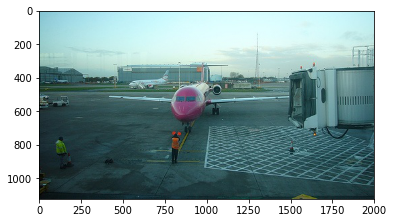

In [23]:
# Pick the first image
x = train_images[0]
# Print the shape. This should be small.
print('Input', x.shape)

# normalize
x = x.astype('float32').transpose((2,0,1)).expand_dims(axis=0)/255

# Create Conv2DTranspose layer
conv_trans = nn.Conv2DTranspose(
    3, in_channels=3, kernel_size=8, padding=2, strides=4)
conv_trans.initialize()
conv_trans(x)

# Set bilinear kernel
conv_trans.weight.set_data(bilinear_kernel(3, 3, 8))

# Pass data through Conv2DTranspose
y = conv_trans(x)
y = y[0].clip(0,1).transpose((1,2,0))
print('Output', y.shape)

# Display the output
plt.imshow(y.asnumpy())
plt.show()

In [24]:
net

HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=True, use_global_stats=False, in_channels=3)
  (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
  (3): Activation(relu)
  (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
  (5): HybridSequential(
    (0): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats

Layers other than the last two are already initialized from model zoo. Let's initialize the last two layers.

In [25]:
# Initialize the last conv layer using xavier
net[-2].initialize(init=init.Xavier())

# Get the transpose conv layer
conv_trans = net[-1]

# We don't know the shape of this layer. So, run a forward pass and find the shape
conv_trans.initialize(init=init.Zero())
x = nd.zeros((batch_size, 3, *input_shape))
net(x)
shape = conv_trans.weight.data().shape

# Initialise with bilinear kernel of correct shape
conv_trans.weight.set_data(bilinear_kernel(*shape[0:3]))

Boiler plate code to run the training loop

In [26]:
def _get_batch(batch, ctx):
    """return features and labels on ctx"""
    if isinstance(batch, mx.io.DataBatch):
        features = batch.data[0]
        labels = batch.label[0]
    else:
        features, labels = batch
    return (gluon.utils.split_and_load(features, ctx),
            gluon.utils.split_and_load(labels, ctx),
            features.shape[0])

def evaluate_accuracy(data_iter, net, ctx=[mx.cpu()]):
    """Evaluate accuracy of a model on the given data set."""
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    acc = nd.array([0])
    n = 0
    if isinstance(data_iter, mx.io.MXDataIter):
        data_iter.reset()
    for batch in data_iter:
        features, labels, batch_size = _get_batch(batch, ctx)
        for X, y in zip(features, labels):
            y = y.astype('float32')
            acc += (net(X).argmax(axis=1)==y).sum().copyto(mx.cpu())
            n += y.size
        acc.wait_to_read() 
    return acc.asscalar() / n

def train(train_iter, test_iter, net, loss, trainer, ctx, num_epochs, print_batches=None):
    """Train and evaluate a model."""
    print("training on ", ctx)
    if isinstance(ctx, mx.Context):
        ctx = [ctx]
    for epoch in range(1, num_epochs + 1):
        train_l_sum, train_acc_sum, n, m = 0.0, 0.0, 0.0, 0.0
        if isinstance(train_iter, mx.io.MXDataIter):
            train_iter.reset()
        start = time()
        for i, batch in enumerate(train_iter):
            Xs, ys, batch_size = _get_batch(batch, ctx)
            ls = []
            with autograd.record():
                y_hats = [net(X) for X in Xs]
                ls = [loss(y_hat, y) for y_hat, y in zip(y_hats, ys)]
            for l in ls:
                l.backward()
            train_acc_sum += sum([(y_hat.argmax(axis=1) == y).sum().asscalar()
                                 for y_hat, y in zip(y_hats, ys)])
            train_l_sum += sum([l.sum().asscalar() for l in ls])
            trainer.step(batch_size)
            n += batch_size
            m += sum([y.size for y in ys])
            if print_batches and (i+1) % print_batches == 0:
                print("batch %d, loss %f, train acc %f" % (
                    n, train_l_sum / n, train_acc_sum / m
                ))
        test_acc = evaluate_accuracy(test_iter, net, ctx)
        print("epoch %d, loss %.4f, train acc %.3f, test acc %.3f, time %.1f sec" % (
            epoch, train_l_sum / n, train_acc_sum / m, test_acc, time() - start
        ))

In [27]:
# Multi class classification for each pixel
loss = gluon.loss.SoftmaxCrossEntropyLoss(axis=1)

# Use GPU
ctx = [mx.gpu(0)]
net.collect_params().reset_ctx(ctx)

# Use SGD optimizer
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': .1, 'wd':1e-3})

# Train
train(train_data, test_data, net, loss, trainer, ctx, num_epochs=10)

training on  [gpu(0)]
epoch 1, loss 1.5447, train acc 0.725, test acc 0.812, time 121.8 sec
epoch 2, loss 0.6067, train acc 0.826, test acc 0.835, time 75.0 sec
epoch 3, loss 0.4634, train acc 0.856, test acc 0.843, time 75.2 sec
epoch 4, loss 0.3899, train acc 0.876, test acc 0.843, time 75.4 sec
epoch 5, loss 0.3529, train acc 0.884, test acc 0.848, time 74.8 sec
epoch 6, loss 0.3228, train acc 0.893, test acc 0.851, time 75.0 sec
epoch 7, loss 0.2965, train acc 0.901, test acc 0.857, time 75.2 sec
epoch 8, loss 0.2671, train acc 0.911, test acc 0.850, time 74.9 sec
epoch 9, loss 0.2498, train acc 0.916, test acc 0.855, time 75.0 sec
epoch 10, loss 0.2379, train acc 0.920, test acc 0.858, time 75.2 sec


Let's run some prediction on the trained model

In [28]:
def predict(im):
    # Normalize the image
    data = normalize_image(im)
    # Channel first. Add an axis for batch
    data = data.transpose((2,0,1)).expand_dims(axis=0)
    # Run the data through the network
    yhat = net(data.as_in_context(ctx[0]))
    # Get indices of highest probability
    pred = nd.argmax(yhat, axis=1)
    # Remove the batch axis
    return pred.reshape((pred.shape[1], pred.shape[2]))

We now have a 2D tensor, each element of which is a class index. Let's convert this to an image.

In [29]:
# Use colormap to convert the prediction to image
def label2image(pred):
    x = pred.astype('int32').asnumpy()
    cm = nd.array(colormap).astype('uint8')
    return nd.array(cm[x,:])

Test with some images.

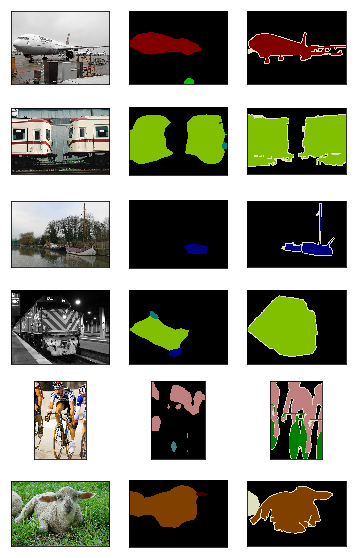

In [30]:
test_images, test_labels = read_dataset(train=False)

n = 6
imgs = []
for i in range(n):
    x = test_images[i]
    pred = label2image(predict(x))
    imgs += [x, pred, test_labels[i]]

show_images(imgs, nrows=n, ncols=3, figsize=(6,10))